# Introduction
This document describes the analysis that took place before writing the final report.

## Loading dependencies

In [20]:
# loading libraries
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import np_utils

from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import seaborn as sns

from keras.preprocessing import image  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential

from tqdm import tqdm

import os
import random
import shutil


## Loading data

In [2]:
# loading data
data = load_files('/seedlings-data/train', load_content=False, shuffle=False)

print(f"There are {len(data['target_names'])} categories")
print (f"These categories are {data['target_names']}")
print (f"There are {len(data['filenames'])} images in training dataset")

There are 12 categories
These categories are ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
There are 4750 images in training dataset


## Visualizations

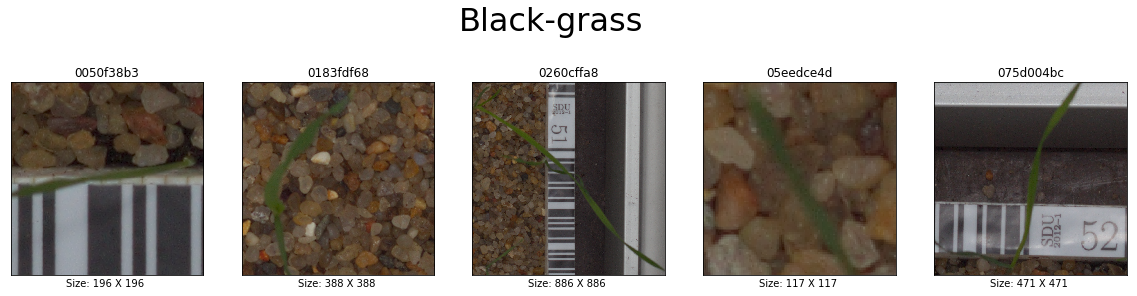

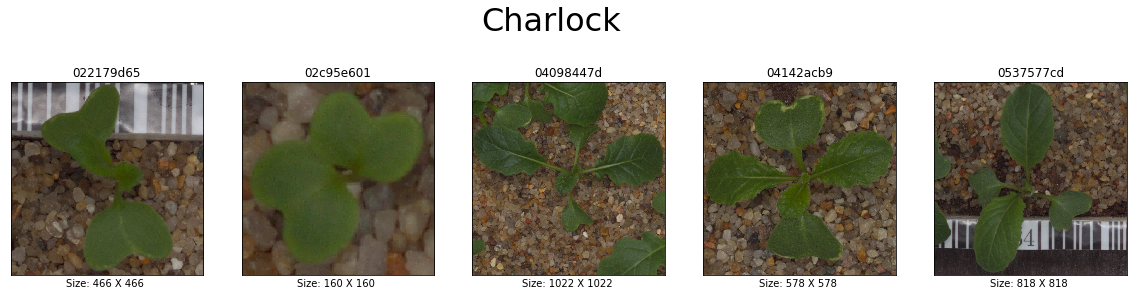

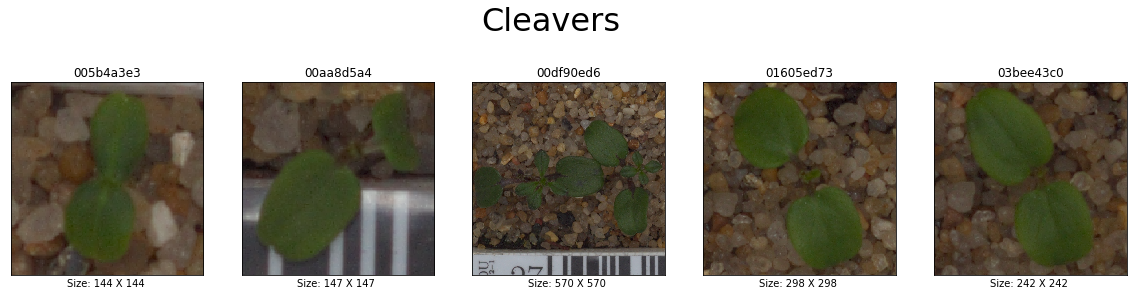

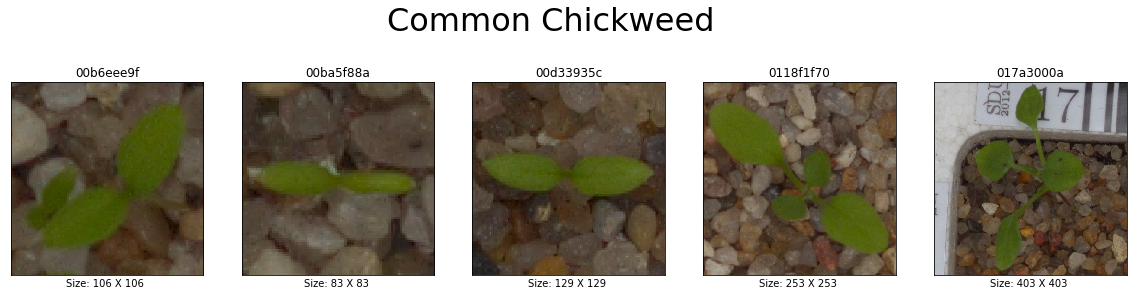

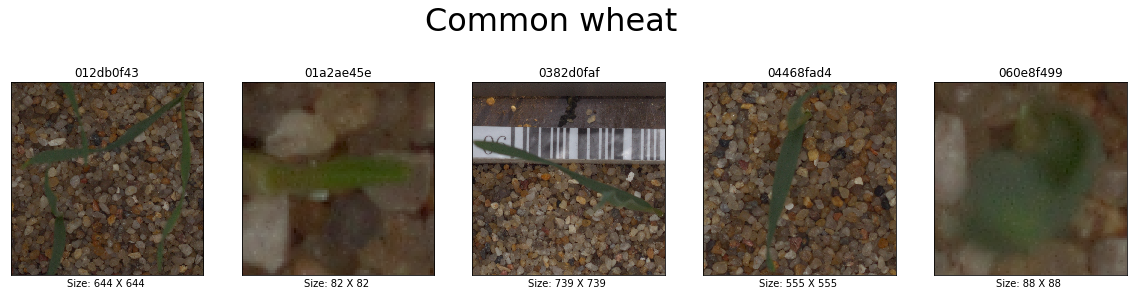

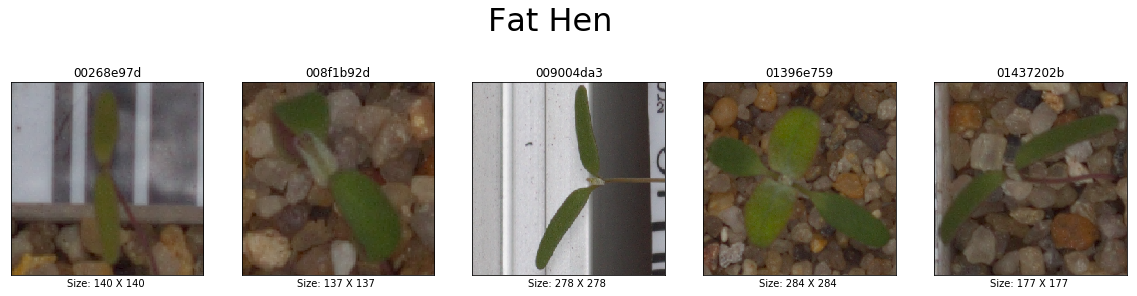

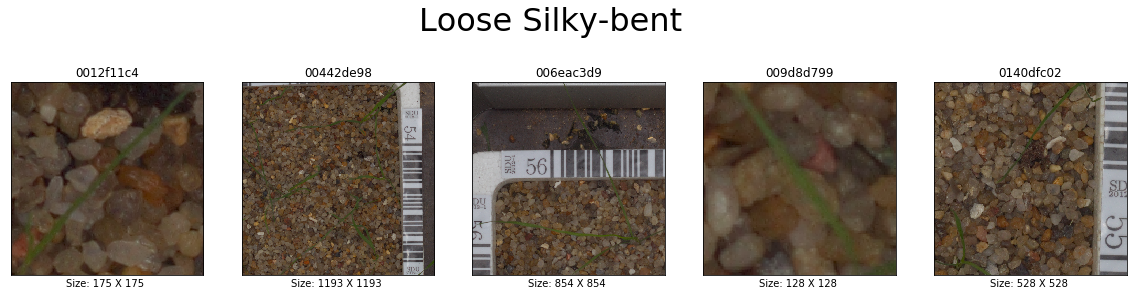

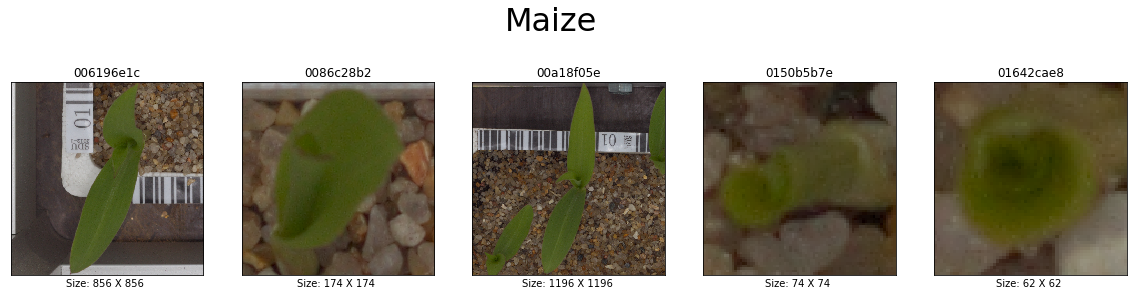

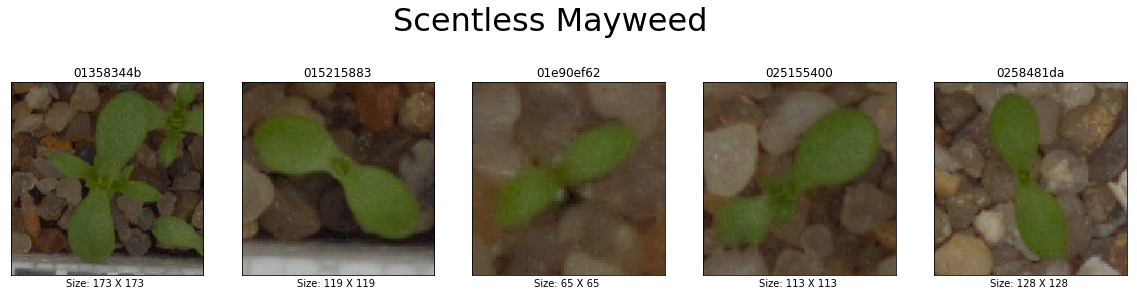

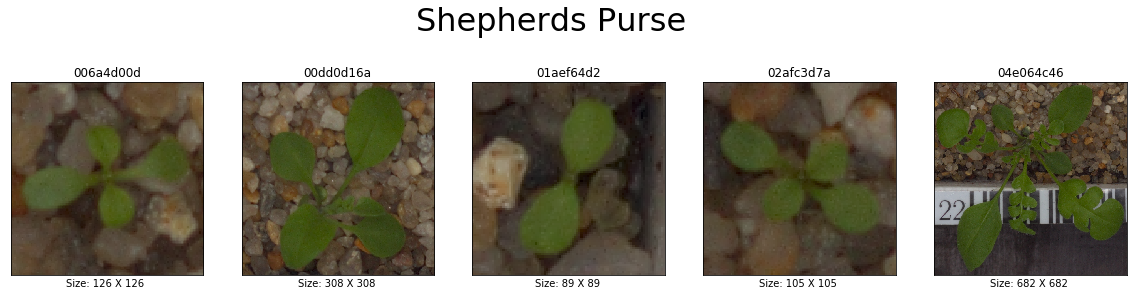

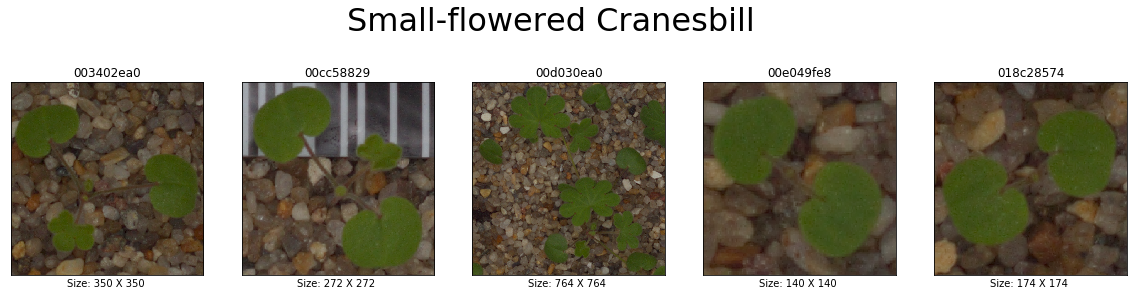

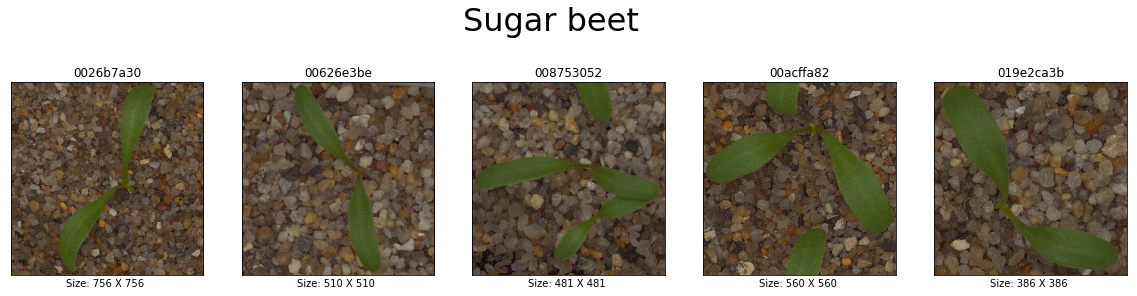

In [3]:
"""
Show 5 samples of each plant species
Each image's title is its filename. Each image's subtitle is it's height and width in pixels.
"""
def display_sample_images(n=5):
    for seedling_id in range(len(data['target_names'])):
        fig = plt.figure(figsize=(20,5))
        fig.suptitle(data['target_names'][seedling_id], fontsize=32)
        img_list = [i for i, j in enumerate(data['target']) if j == seedling_id]
        for i in range(n):
            seedling_file = data['filenames'][img_list[i]]
            filename = seedling_file[-13:-4]
            with Image.open(seedling_file) as img:
                ax = fig.add_subplot(1, n, i+1, xticks=[], yticks=[])
                ax.set_title(filename)
                ax.set_xlabel("Size: %d X %d " % (img.size[0], img.size[1]))
                ax.imshow(mpimg.imread(seedling_file))
        plt.show()

display_sample_images()

## Splitting data into train and test set

In [4]:
"""
Spliting data into a training and a testing set.
"""
def split_data_train_and_test(data, test_section = 0.1):
    x = np.array(data['filenames'])
    y = np.array(data['target'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_section, random_state=0)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data_train_and_test(data)

## One hot encoding targets

In [5]:
"""
Targets are one-hot-encoded by converting them from integers to vectors with a length 
equal to the number of plant species
"""
y_train_targets = np_utils.to_categorical(y_train, len(data['target_names']))
y_test_targets = np_utils.to_categorical(y_test, len(data['target_names']))

## Plot the plant distribution

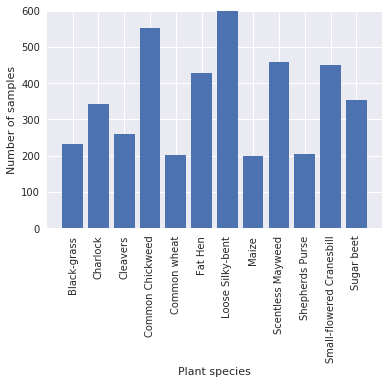

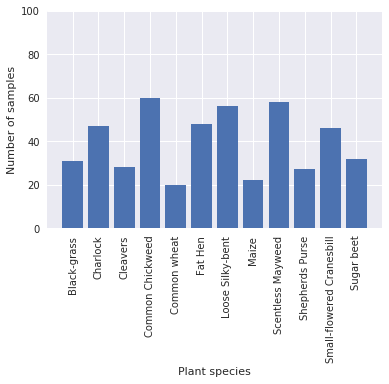

In [6]:
"""
Plot the distribution of samples across all plant species
"""
def plot_class_distribution(targets, ylim):
    labels = np.array(data['target_names']) 
    fig, ax = plt.subplots()
    x_pos = np.arange(len(labels))
    train_labels = np.sum(targets, axis=0)
    ax.bar(x_pos, train_labels, align='center')
    ax.set_ylim(0, ylim)
    plt.xticks(x_pos, labels, rotation='vertical')
    plt.xlabel("Plant species")
    plt.ylabel("Number of samples")
    plt.show()

sns.set(color_codes=True) 
plot_class_distribution(y_train_targets, 600)
plot_class_distribution(y_test_targets, 100)

## Images to tensors

In [7]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensors(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
# Create the tensors from x_train and x_test
x_train_tensors = paths_to_tensors(x_train)
x_test_tensors = paths_to_tensors(x_test)

100%|██████████| 475/475 [00:05<00:00, 82.12it/s] 


## Augmenting data
The data augmentation I used was based on
[https://machinelearningmastery.com/image-augmentation-deep-learning-keras/](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) and 
[https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [9]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [10]:
def empty_augmented_data_directory(path):
    if os.path.isdir(path): 
        shutil.rmtree(path)
    os.makedirs(path)


def image_augmentation(x_train_tensors, y_train, labels, batch_size):
    path = '/output/augmented_images'
    empty_augmented_data_directory(path)
    for seedling_id in range(len(data['target_names'])):
        target_dir = '%s/%s' % (path, labels[seedling_id])
        os.makedirs(target_dir)
        
        images = [i for i, j in enumerate(y_train) if j == seedling_id]
        random.shuffle(images)
        
        images = (images * (batch_size // len(images))) + images[0:batch_size % len(images)]        

        n_images = x_train_tensors[images]
        for batch in datagen.flow(n_images, batch_size=batch_size, save_to_dir=target_dir, save_format='png'):
            break

In [11]:
# The augmented data only needs to be created once. As it takes a long time to create 
# and I pay floydhub.com by the minute the following line is commented out.
#image_augmentation(x_train_tensors, y_train, np.array(data['target_names']), 2500)

In [12]:
# The augmented_images were downloaded and uploaded back to floydhub as a dataset
augmented_data = load_files('/augmented_images', load_content=False, shuffle=False)
print (f"There are {len(augmented_data['filenames'])} images in training dataset")

There are 30000 images in training dataset


In [14]:
# Naturally the augmented images have to be tensorized and hot_encoded also
x_augmented = np.array(augmented_data['filenames'])
x_augmented_tensors = paths_to_tensors(x_augmented)
y_augmented = np.array(augmented_data['target'])
y_augmented_targets = np_utils.to_categorical(y_augmented, len(data['target_names']))

100%|██████████| 30000/30000 [01:18<00:00, 379.78it/s]


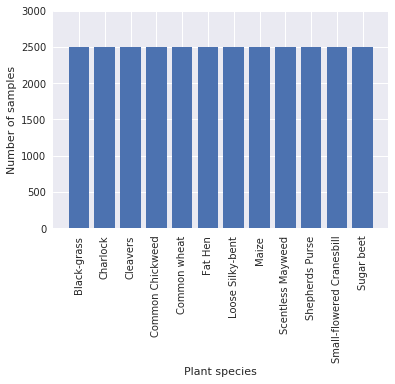

In [16]:
# plotting the augmented data
sns.set(color_codes=True) 
plot_class_distribution(y_augmented_targets, 3000)

## Defining a homemade CNN
Starting with the same model I used on the dog classifier project 

In [22]:
basic_model = Sequential()

### DONE: Define your architecture.
basic_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=x_train_tensors[0].shape))
basic_model.add(MaxPooling2D(pool_size=2))

basic_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=2))

basic_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
basic_model.add(MaxPooling2D(pool_size=2))

basic_model.add(Dropout(0.2))
basic_model.add(Flatten())

basic_model.add(Dense(500, activation='relu'))
basic_model.add(Dense(133, activation='softmax'))
basic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________